In [1]:
# Import nessary libraries
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.cliffwalking import CliffWalkingEnv
from gymnasium.error import DependencyNotInstalled
from os import path
import json

In [2]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

ACTIONS = [UP, RIGHT, DOWN, LEFT]

MAX_CELL = 48

P_PROB = 3/4
Q_PROB = 1/8

image_path = path.join(path.dirname(gym.__file__), "envs", "toy_text")

In [3]:
class CliffWalking(CliffWalkingEnv):
    def __init__(self, is_hardmode=True, num_cliffs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.is_hardmode = is_hardmode

        # Generate random cliff positions
        if self.is_hardmode:
            self.num_cliffs = num_cliffs
            self._cliff = np.zeros(self.shape, dtype=bool)
            self.start_state = (3, 0)
            self.terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
            self.cliff_positions = []
            while len(self.cliff_positions) < self.num_cliffs:
                new_row = np.random.randint(0, 4)
                new_col = np.random.randint(0, 11)
                state = (new_row, new_col)
                if (
                    (state not in self.cliff_positions)
                    and (state != self.start_state)
                    and (state != self.terminal_state)
                ):
                    self._cliff[new_row, new_col] = True
                    if not self.is_valid():
                        self._cliff[new_row, new_col] = False
                        continue
                    self.cliff_positions.append(state)

        # Calculate transition probabilities and rewards
        self.P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            self.P[s] = {a: [] for a in range(self.nA)}
            self.P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            self.P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            self.P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            self.P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        if self._cliff[tuple(new_position)]:
            return [(1.0, self.start_state_index, -100, False)]

        terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
        is_terminated = tuple(new_position) == terminal_state
        return [(1 / 3, new_state, -1, is_terminated)]

    # DFS to check that it's a valid path.
    def is_valid(self):
        frontier, discovered = [], set()
        frontier.append((3, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= self.shape[0] or c_new < 0 or c_new >= self.shape[1]:
                        continue
                    if (r_new, c_new) == self.terminal_state:
                        return True
                    if not self._cliff[r_new][c_new]:
                        frontier.append((r_new, c_new))
        return False

    def step(self, action):
        if action not in [0, 1, 2, 3]:
            raise ValueError(f"Invalid action {action}   must be in [0, 1, 2, 3]")

        if self.is_hardmode:
            match action:
                case 0:
                    action = np.random.choice([0, 1, 3], p=[P_PROB, Q_PROB, Q_PROB])
                case 1:
                    action = np.random.choice([0, 1, 2], p=[Q_PROB, P_PROB, Q_PROB])
                case 2:
                    action = np.random.choice([1, 2, 3], p=[Q_PROB, P_PROB, Q_PROB])
                case 3:
                    action = np.random.choice([0, 2, 3], p=[Q_PROB, Q_PROB, P_PROB])

        return super().step(action)

    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[toy-text]`"
            ) from e
        if self.window_surface is None:
            pygame.init()

            if mode == "human":
                pygame.display.init()
                pygame.display.set_caption("CliffWalking - Edited by Audrina & Kian")
                self.window_surface = pygame.display.set_mode(self.window_size)
            else:  # rgb_array
                self.window_surface = pygame.Surface(self.window_size)
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.elf_images is None:
            hikers = [
                path.join(image_path, "img/elf_up.png"),
                path.join(image_path, "img/elf_right.png"),
                path.join(image_path, "img/elf_down.png"),
                path.join(image_path, "img/elf_left.png"),
            ]
            self.elf_images = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in hikers
            ]
        if self.start_img is None:
            file_name = path.join(image_path, "img/stool.png")
            self.start_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.goal_img is None:
            file_name = path.join(image_path, "img/cookie.png")
            self.goal_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.mountain_bg_img is None:
            bg_imgs = [
                path.join(image_path, "img/mountain_bg1.png"),
                path.join(image_path, "img/mountain_bg2.png"),
            ]
            self.mountain_bg_img = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in bg_imgs
            ]
        if self.near_cliff_img is None:
            near_cliff_imgs = [
                path.join(image_path, "img/mountain_near-cliff1.png"),
                path.join(image_path, "img/mountain_near-cliff2.png"),
            ]
            self.near_cliff_img = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in near_cliff_imgs
            ]
        if self.cliff_img is None:
            file_name = path.join(image_path, "img/mountain_cliff.png")
            self.cliff_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        for s in range(self.nS):
            row, col = np.unravel_index(s, self.shape)
            pos = (col * self.cell_size[0], row * self.cell_size[1])
            check_board_mask = row % 2 ^ col % 2
            self.window_surface.blit(self.mountain_bg_img[check_board_mask], pos)

            if self._cliff[row, col]:
                self.window_surface.blit(self.cliff_img, pos)
            if s == self.start_state_index:
                self.window_surface.blit(self.start_img, pos)
            if s == self.nS - 1:
                self.window_surface.blit(self.goal_img, pos)
            if s == self.s:
                elf_pos = (pos[0], pos[1] - 0.1 * self.cell_size[1])
                last_action = self.lastaction if self.lastaction is not None else 2
                self.window_surface.blit(self.elf_images[last_action], elf_pos)

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

In [4]:
def draw_grid(directions, no_arrow_positions = []):
    rows = 4
    columns = 12
    cell_size = 1

    fig, ax = plt.subplots()

    for row in range(rows):
        for col in range(columns):
            index = row * columns + col
            direction = directions.get(index, None)

            if direction is not None and index not in no_arrow_positions:
                x = col * cell_size + cell_size / 2
                y = (rows - 1 - row) * cell_size + cell_size / 2

                if direction == 0:  # Upward arrow
                    ax.arrow(x, y, 0, cell_size / 4, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 1:  # Right arrow
                    ax.arrow(x, y, cell_size / 4, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 2:  # Downward arrow
                    ax.arrow(x, y, 0, -cell_size / 4, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 3:  # Left arrow
                    ax.arrow(x, y, -cell_size / 4, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
            elif index in no_arrow_positions:
                ax.add_patch(plt.Rectangle((col, rows - 1 - row), 1, 1, color='black'))

    ax.set_aspect('equal')
    ax.set_xlim(0, columns)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [5]:
def draw_values(data, cell_width=1, cell_height=1):
    # Prepare data for plotting
    values = [data.get(i, 0) for i in range(48)]

    # Reshape the values into a 4x12 grid
    grid_values = [values[i:i+12] for i in range(0, len(values), 12)]

    # Calculate the total size of the figure
    fig_width = 12 * cell_width
    fig_height = 4 * cell_height

    # Create the plot with specified figure size
    plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(grid_values, cmap='viridis', interpolation='nearest')

    # Add text annotations with values formatted to 3 decimal places
    for i in range(4):
        for j in range(12):
            plt.text(j, i, '{:.3f}'.format(grid_values[i][j]), ha='center', va='center', color='black')

    # Customize plot aesthetics
    plt.title('Grid Visualization')
    plt.colorbar(label='Values')
    plt.xticks(range(12), range(12))
    plt.yticks(range(4), range(4))
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.grid(visible=False)
    plt.show()

In [6]:
def get_s_pos(s):
    r = s // 12
    c = s % 12
    return (r, c)

In [7]:
def get_s_cell(s):
    return s[0] * 12 + s[1]

In [8]:
def actions(s):
    pos_r, pos_c = get_s_pos(s)

    A = []

    if pos_r != 0:
        A.append(UP)
    if pos_r != 3:
        A.append(DOWN)
    if pos_c != 0:
        A.append(LEFT)
    if pos_c != 11:
        A.append(RIGHT)

    return A

In [9]:
def T(env, s, a, p = 1/2, q = 1/4):
    S = []
    res = result(s, a)
    
    for i, sp in enumerate(res):
        if i == 0:
            S.append((p, sp, reward_action(env, sp)))
        else:
            pos_r, pos_c = get_s_pos(sp)
            if pos_r > 3 or pos_r < 0 or pos_c > 11 or pos_c < 0:
                S.append((q, s, reward_action(env, s)))
            else:
                S.append((q, sp, reward_action(env, sp)))
                
    return S

In [10]:
def result(s, a):
    pos_r, pos_c = get_s_pos(s)
    res = []
    
    if a == UP:
        res.append(result_definite(s, UP))
        if pos_c != 11:
            res.append(result_definite(s, RIGHT))
        if pos_c != 0:
            res.append(result_definite(s, LEFT))
                
    if a == RIGHT:
        res.append(result_definite(s, RIGHT))
        if pos_r != 0:
            res.append(result_definite(s, UP))
        if pos_r != 3:
            res.append(result_definite(s, DOWN))
                
    if a == LEFT:
        res.append(result_definite(s, LEFT))
        if pos_r != 0:
            res.append(result_definite(s, UP))
        if pos_r != 3:
            res.append(result_definite(s, DOWN))
    
    if a == DOWN:
        res.append(result_definite(s, DOWN))
        if pos_c != 11:
            res.append(result_definite(s, RIGHT))
        if pos_c != 0:
            res.append(result_definite(s, LEFT))
    
    return res

In [11]:
def result_definite(s, a):
    if a == UP:
        return s - 12
    if a == RIGHT:
        return s + 1
    if a == DOWN:
        return s + 12
    if a == LEFT:
        return s - 1

In [12]:
def reward_action(env, state):
    cliff_positions = [get_s_cell(x) for x in env.cliff_positions]
    
    # if state == 47:
    #     return 2000
    # if state in cliff_positions:
    #     return -100
    return -1

In [13]:
def initialize():
    my_env = {}
    for state in range(MAX_CELL):
        my_env[state] = {}
        for action in actions(state):
            my_env[state][action] = []
            for transition in T(env, state, action, p = P_PROB, q = Q_PROB):
                my_env[state][action].append(transition)
                
    return my_env

In [14]:
def value_iteration(my_env, env, discount_factor):
    v = {} # cell number => state value
    vp = {}

    delta = 0

    q = {} # cell number => [UP, RIGHT, DOWN, LEFT] values
    p = {} # cell number => action (UP, RIGHT, DOWN, LEFT)

    P = env.P
    cliff_positions = [get_s_cell(x) for x in env.cliff_positions]
    
    for i in range(MAX_CELL):
        vp[i] = 0
        q[i] = [0, 0, 0, 0]
        p[i] = 0
    
    t = 0
    max_iter = 100000
    #draw_grid(p, cliff_positions)
    while t < max_iter: # TODO: Add convergence
        v = vp.copy()
        for s in range(MAX_CELL):
            if s == 47:
                max_q_value = 2000
                max_q_action = UP
            
            elif s in cliff_positions:
                max_q_value = -100
                max_q_action = UP
                
            else:
                q[s] = [0, 0, 0, 0]
                for a in actions(s):
                    for prob, sp, reward in my_env[s][a]:
                        q[s][a] += prob * (reward + discount_factor * v[sp])

                max_q_value = q[s][actions(s)[0]]
                max_q_action = actions(s)[0]
                for ac in actions(s):
                    if q[s][ac] > max_q_value:
                        max_q_value = q[s][ac]
                        max_q_action = ac

            vp[s] = max_q_value
            p[s] = max_q_action
            
        
        # time.sleep(5)
        # if t % 2 == 0:
        #     print(vp[36])
        if t < 20 or t > max_iter - 10:
            draw_grid(p, cliff_positions)
            draw_values(vp)

        t += 1
    draw_grid(p, cliff_positions)
    draw_values(vp)
        
    return p, v, q

In [38]:
def policy_evaluation(my_env, env, p, discount_factor, max_iter = 1000):
    v = {}
    vp = {}
    q = {}
    
    cliff_positions = [get_s_cell(x) for x in env.cliff_positions]
    
    for state in range(MAX_CELL):
        vp[state] = 0
        q[state] = {}
        for action in actions(state):
            q[state][action] = 0
    
    t = 1
    while t < max_iter:
        t += 1
        
        v = vp.copy()
        
        for state in range(MAX_CELL):
            if state == 47:
                q_value = 2000
            
            elif state in cliff_positions:
                q_value = -100
                
            else:
                for action in actions(state):
                    q[state][action] = 0
                    for prob, sp, reward in my_env[state][action]:
                        q[state][action] += prob * (reward + discount_factor * v[sp])

                q_value = q[state][p[state]]
            
            vp[state] = q_value
          
    return vp, q

In [39]:
def policy_iteration(my_env, env, max_iter):
    p = {}
    v = {}
    for i in range(MAX_CELL):
        p[i] = np.random.choice(actions(i))

    discount_factor = 0.9
    cliff_positions = [get_s_cell(x) for x in env.cliff_positions]

    t = 1
    while t < max_iter:
        t += 1
        v, q = policy_evaluation(my_env, env, p, discount_factor, max_iter = 1000)
        for state in range(MAX_CELL):
            max_q_action = max(q[state], key=q[state].get)
            p[state] = max_q_action

        if t < 10:
            draw_grid(p, cliff_positions)
            draw_values(v)
    
    draw_grid(p, cliff_positions)
    draw_values(v)
    return p, v

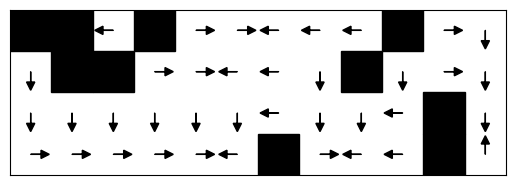

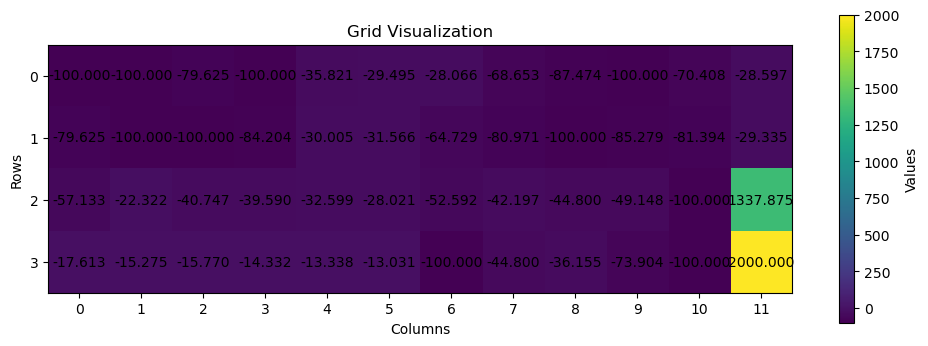

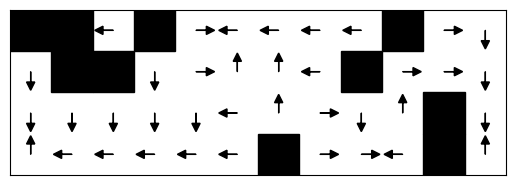

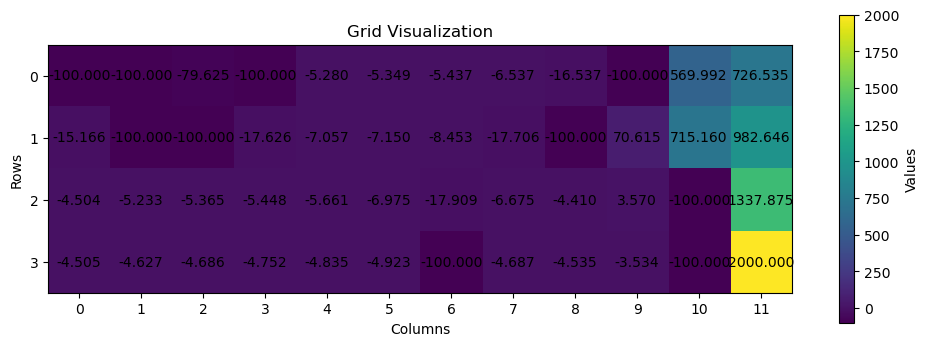

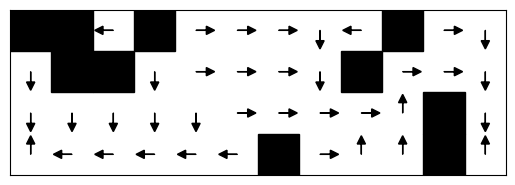

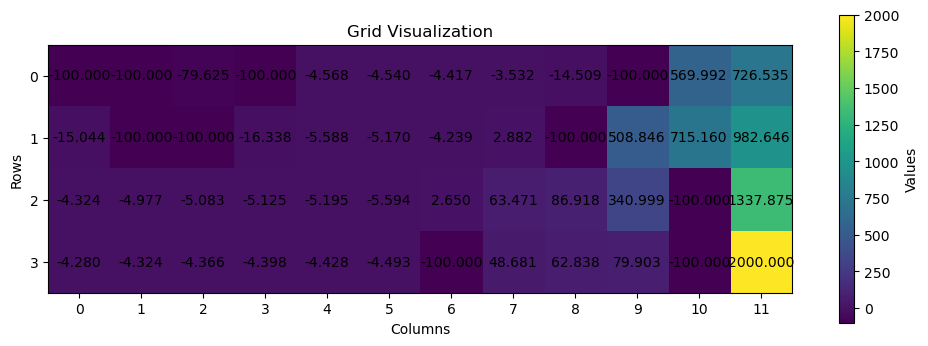

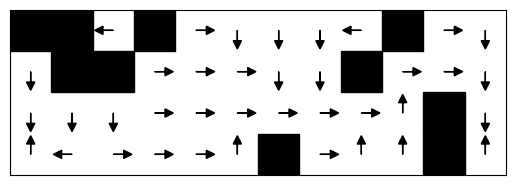

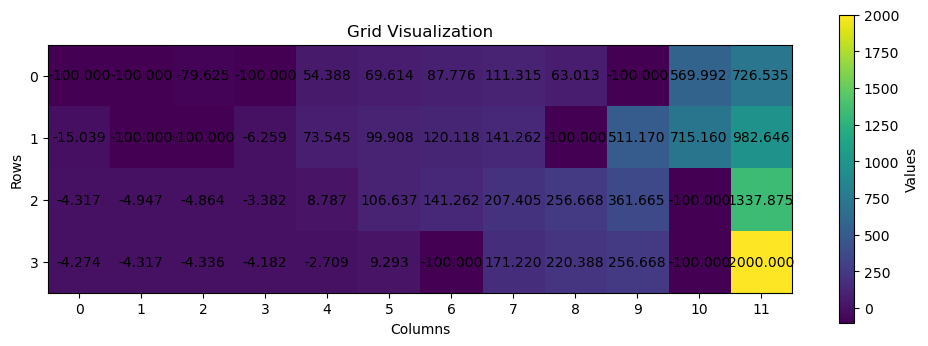

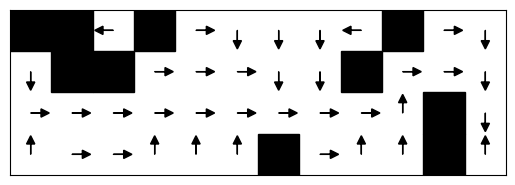

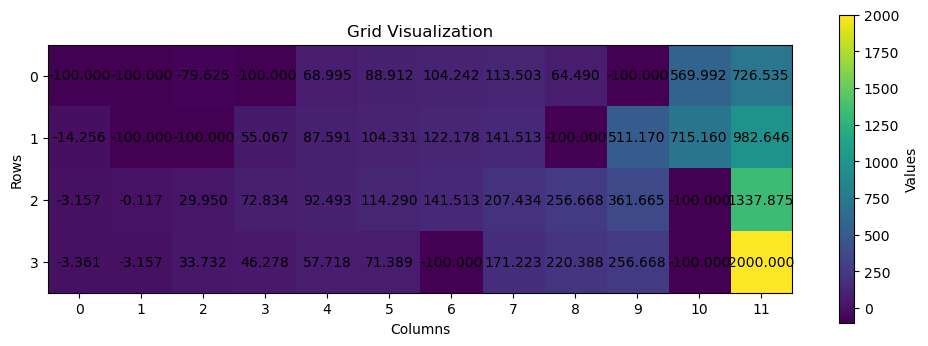

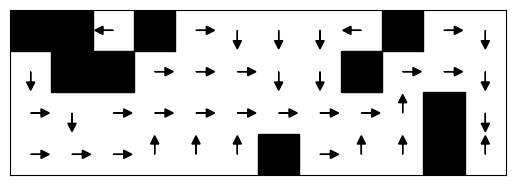

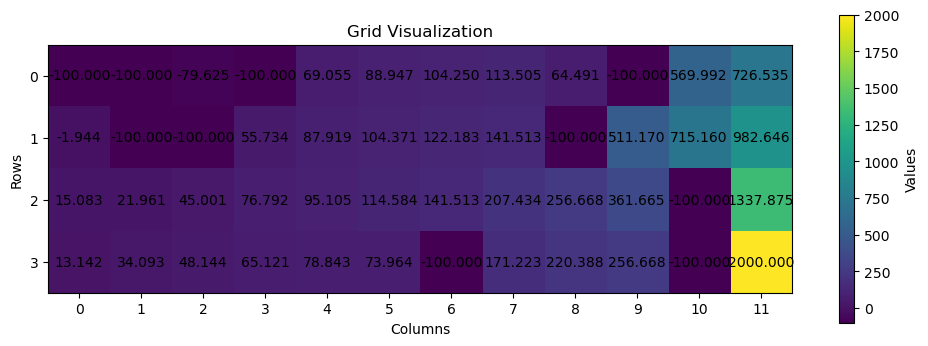

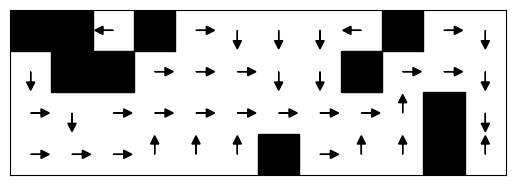

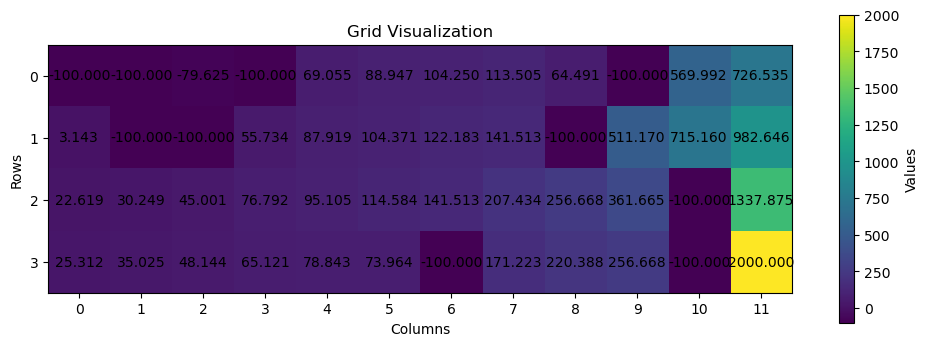

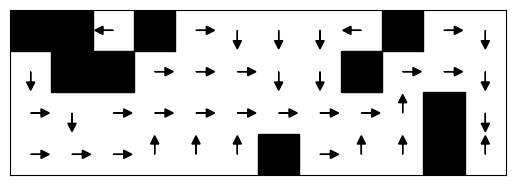

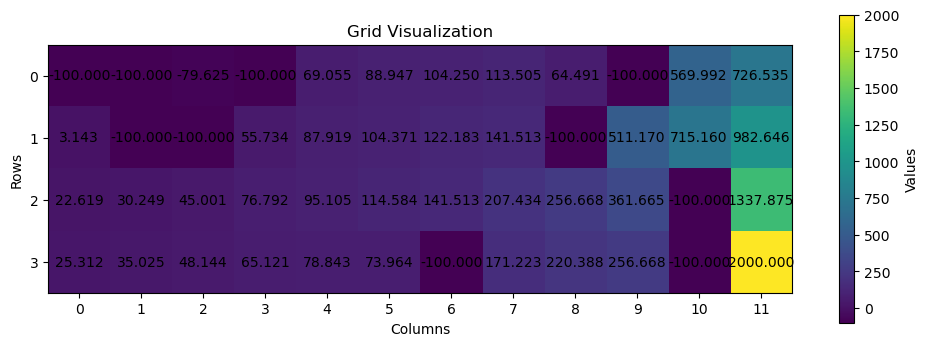

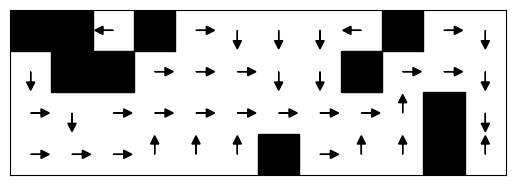

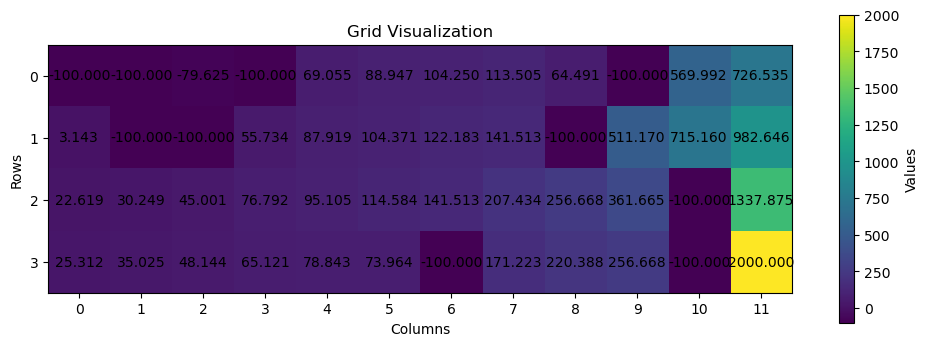

In [ ]:
# Create an environment
env = CliffWalking(render_mode="human")

observation, info = env.reset(seed=30)
my_env = initialize()

# Saving my_env into a file
with open('map_data.json', 'w') as json_file:
    json.dump(my_env, json_file, indent=2)

p, v = policy_iteration(my_env, env, 50)

# Define the maximum number of iterations
max_iter_number = 1000
state = observation
for __ in range(max_iter_number):
    # Note: .sample() is used to sample random action from the environment's action space
    # Choose an action (Replace this random action with your agent's policy)
    action = p[state]

    # Perform the action and receive feedback from the environment
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done or truncated:
        observation, info = env.reset()
        state = observation

# Close the environment
env.close()


In [ ]:
print("cliff_positions:", env.cliff_positions)
print("start_state:", env.start_state)
print("terminal_state:", env.terminal_state)
